In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

In [13]:
baseline_and_sota = {
    'ICU Prediction': 
        {'CLMBR': 0.0337704575679725}, 
    'Long LOS': 
        {'CLMBR': 0.1453075561418501}, 
    '30-Day Readmission': 
        {'CLMBR': 0.0860665650869187}, 
    'Anemia': 
        {'CLMBR': 0.0697850341693531}, 
    'Hyponatremia': 
        {'CLMBR': 0.167271410579661}, 
    'Thrombocytopenia': 
        {'CLMBR': 0.1400265531406942}, 
    'Hyperkalemia': 
        {'CLMBR': 0.0222092064064669}, 
    'Hypoglycemia': 
        {'CLMBR': 0.0129362018710936}, 
    'Acute MI': 
        {'CLMBR': 0.059816149346027}, 
    'Lupus': 
        {'CLMBR': 0.0122419472014198}, 
    'Hyperlipidemia':
        {'CLMBR': 0.1107625256252553}, 
    'Hypertension': 
        {'CLMBR': 0.1037615926587521}, 
    'Celiac': 
        {'CLMBR': 0.0354831840398113}, 
    'Pancreatic Cancer': 
        {'CLMBR': 0.0245539621126201}, 
    'Chexpert': 
        {'CLMBR': 0.713}
}


In [14]:
folder_to_name_mapping = {
    'guo_los': 'Long LOS',
    'guo_icu': 'ICU Prediction',
    'guo_readmission': '30-Day Readmission',
    'lab_anemia': 'Anemia',
    'lab_hyperkalemia': 'Hyperkalemia',
    'lab_hypoglycemia': 'Hypoglycemia',
    'lab_hyponatremia': 'Hyponatremia',
    'lab_thrombocytopenia': 'Thrombocytopenia',
    'new_acutemi': 'Acute MI',
    'new_celiac': 'Celiac',
    'new_hyperlipidemia': 'Hyperlipidemia',
    'new_hypertension': 'Hypertension',
    'new_lupus': 'Lupus',
    'new_pancan': 'Pancreatic Cancer',
    'chexpert': 'Chexpert'
}

In [15]:
# Function to clean and extract relevant information from the CSV
def clean_and_extract(df):
    # Select and clean relevant columns, including the replicate column and bounds
    df = df[['sub_task', 'model', 'k', 'score', 'value', 'replicate', 'lower', 'upper']]
    df['model'] = df['model'].str.split('--clmbr_train').str[0]
    
    # Filter for BRIER scores
    df = df[(df['k'] == -1) & (df['score'] == 'brier')]
    
    # Extract architecture and context length
    df['architecture'] = df['model'].apply(lambda x: x.split('-')[0])
    
    # Exclude BERT from the data
    df = df[df['architecture'] != 'bert']
    
    # Extract context length safely and ensure it's an integer
    df['context_length'] = df['model'].apply(lambda x: int(x.split('-')[2]) if len(x.split('-')) > 2 and x.split('-')[2].isdigit() else None)
    
    # Filter out rows related to GPT vocab size variations
    df = df[~df['model'].str.contains('--clmbr-')]
    
    # Group by task, model, architecture, context length, and calculate mean and bounds for replicates
    df_grouped = df.groupby(['sub_task', 'model', 'architecture', 'context_length']).agg(
        value_mean=('value', 'mean'),
        lower_bound=('lower', 'mean'),
        upper_bound=('upper', 'mean')
    ).reset_index()
    
    return df_grouped

In [16]:
def process_all_tasks_for_plotting():
    ehrshot_dir = '/share/pi/nigam/migufuen/ehrshot-benchmark/EHRSHOT_ASSETS/results_ehrshot'  # Point to the 'ehrshot' directory
    combined_summary = pd.DataFrame()
    include_models = [
        'gpt2-base-512--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'gpt2-base-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'gpt2-base-2048--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'gpt2-base-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'hyena-large-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'hyena-large-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'hyena-large-8192--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'hyena-large-16384--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'llama-base-512--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'llama-base-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'llama-base-2048--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'llama-base-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'mamba-tiny-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'mamba-tiny-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
        'mamba-tiny-8192--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last',
        'mamba-tiny-16384--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    ]
    
    exclude_tasks = [
        # 'new_lupus',
        # 'new_celiac',
        'chexpert'
    ]
    for task_name in os.listdir(ehrshot_dir):
        task_path = os.path.join(ehrshot_dir, task_name)
        if os.path.isdir(task_path) and task_name not in exclude_tasks:
                try:
                    print(f"Processing task: {task_name}")
                    # Read and clean data
                    input_file = os.path.join(task_path, 'all_results.csv')
                    df = pd.read_csv(input_file)
                    df = df[df['model'].isin(include_models)]
                    df_cleaned = clean_and_extract(df)
                    df_cleaned['task_name'] = folder_to_name_mapping.get(task_name, task_name)
                    
                    # Map the task name to a human-readable name
                    if task_name == 'chexpert':
                        df_cleaned = df_cleaned.groupby(['architecture', 'context_length', 'model', 'task_name']).agg({
                            'value_mean': 'mean',
                            'lower_bound': 'mean',
                            'upper_bound': 'mean'
                        }).reset_index()
                        df_cleaned['sub_task'] = df_cleaned['task_name']
                    combined_summary = pd.concat([combined_summary, df_cleaned], ignore_index=True)
                    
                except Exception as e:
                    print(f"Failed to process task {task_name}: {e}")
    combined_summary ['architecture'] = combined_summary['architecture'].replace('gpt2', 'gpt')

    return combined_summary

In [17]:
# Merge the baseline and state-of-the-art BRIER scores into the combined summary
def merge_baseline_sota(df, baseline_and_sota):
    # Create lists to store each baseline model's BRIER
    clmbr_list = []

    # Iterate over each task in the DataFrame
    for task_name in df['task_name'].unique():
        if task_name in baseline_and_sota:
            clmbr_brier = baseline_and_sota[task_name].get('CLMBR')
        else:
            clmbr_brier = None
        
        clmbr_list.extend([clmbr_brier] * len(df[df['task_name'] == task_name]))

    # Add these lists as columns to the DataFrame
    df['CLMBR_BRIER'] = clmbr_list
    
    return df

In [18]:
   # Function to plot all tasks in one frame
def plot_all_tasks_in_one_frame(combined_summary, save_path):
    # Sort context lengths uniformly
    combined_summary = combined_summary.sort_values('context_length')
    nan_rows = combined_summary[combined_summary.isna().any(axis=1)]
    # Ensure all tasks have the same context lengths by adding missing ones with NaN
    context_lengths = combined_summary['context_length'].unique()
    architectures = combined_summary['architecture'].unique()
    
    # Reindex for each task to ensure consistency in context lengths
    reindexed_data = []
    for task_name, task_data in combined_summary.groupby('task_name'):
        task_data = task_data.drop_duplicates(subset=['context_length', 'architecture'])
        task_data = task_data.set_index(['context_length', 'architecture']).reindex(
            pd.MultiIndex.from_product([context_lengths, architectures], names=['context_length', 'architecture']),
            fill_value=np.nan
        ).reset_index()
        task_data['task_name'] = task_name
        reindexed_data.append(task_data)
    combined_summary = pd.concat(reindexed_data, ignore_index=True)
    
    # Facet grid with one plot per task
    g = sns.FacetGrid(combined_summary, col="task_name", col_wrap=3, height=4, aspect=1.5, sharey=False, sharex=False, despine=False)
    
    # Plotting the line plots with architecture as hue
    g.map(sns.lineplot, "context_length", "value_mean", "architecture", marker='o', errorbar=None, palette="tab10", linewidth=2)
    
    # Adjust the y-axis for each subplot individually
    for ax, (task_name, task_data) in zip(g.axes.flat, combined_summary.groupby('task_name')):
        for spine in ax.spines.values():  # Add borders to the subplots
            spine.set_edgecolor('black')
            
        y_min = task_data['value_mean'].min()
        y_max = task_data['value_mean'].max()
        
        # Adjust the axis limits dynamically
        ax.set_ylim([y_min - 0.001, y_max + 0.001])
        # ax.set_ylim([0, 0.2])
        ax.set_xlabel("Context Length")
        ax.set_ylabel("BRIER Score")
        
        # Find the row with the highest BRIER from the models
        best_row = task_data.loc[task_data['value_mean'].idxmin()]
        best_architecture = best_row['architecture']
        best_context_length = best_row['context_length']
        best_brier = best_row['value_mean']
        
        # Get the baseline and state of the art BRIERs
        if task_name in baseline_and_sota:
            clmbr_brier = baseline_and_sota[task_name]['CLMBR']
            
            # Determine the best overall model (max of all baselines and CLMBR)
            baseline_max_brier = clmbr_brier
            if best_brier > baseline_max_brier:
                best_architecture = 'Prior SOTA'
                best_context_length = 'N/A'  # Baseline models and CLMBR are not dependent on context length
            
            # Plot the baseline models as horizontal dotted lines
            ax.axhline(y=baseline_max_brier, color='purple', linestyle='--', linewidth=1.5, label='Prior SOTA')
                
        ax.set_title(
            f"{task_name}\nBest: {best_architecture}, {best_context_length}, BRIER={best_brier:.3f}",
            fontsize=10,
            fontweight='bold',
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3')
        )
    
    # Adjust layout to fit the title and increase spacing between subplots
    plt.subplots_adjust(top=0.89, hspace=0.4, wspace=0.3)
    
    # Add the legend manually for the baseline and state of the art
    unique_handles_labels = {}

    # Iterate over all axes in the figure
    for ax in g.axes.flat:
        handles, labels = ax.get_legend_handles_labels()
        
        # Add only unique labels and corresponding handles to the dictionary
        for handle, label in zip(handles, labels):
            if label not in unique_handles_labels:
                unique_handles_labels[label] = handle

    g.fig.legend(handles=unique_handles_labels.values(), labels=unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=len(unique_handles_labels.keys()), fontsize=12)
    g.savefig(save_path)
    plt.show()
    
    combined_summary_sorted = merge_baseline_sota(combined_summary, baseline_and_sota)
    combined_summary_sorted = combined_summary_sorted.dropna()
    output_csv_path = "brier_summary_table_context_length_architectire.csv"
    combined_summary_sorted = combined_summary_sorted.sort_values(by=['task_name', 'value_mean'], ascending=[True, False])
    combined_summary_sorted[['task_name', 'model', 'value_mean', 'lower_bound', 'upper_bound', 'CLMBR_BRIER']].to_csv(output_csv_path, index=False)
    print(f"\nBRIER Summary Table saved to {output_csv_path}")

Processing task: new_hypertension
Processing task: guo_los
Processing task: lab_hypoglycemia
Processing task: new_lupus
Processing task: lab_hyponatremia
Processing task: new_pancan
Processing task: lab_anemia
Processing task: new_acutemi
Processing task: guo_readmission
Processing task: lab_thrombocytopenia
Processing task: new_hyperlipidemia
Processing task: new_celiac
Processing task: lab_hyperkalemia
Processing task: guo_icu


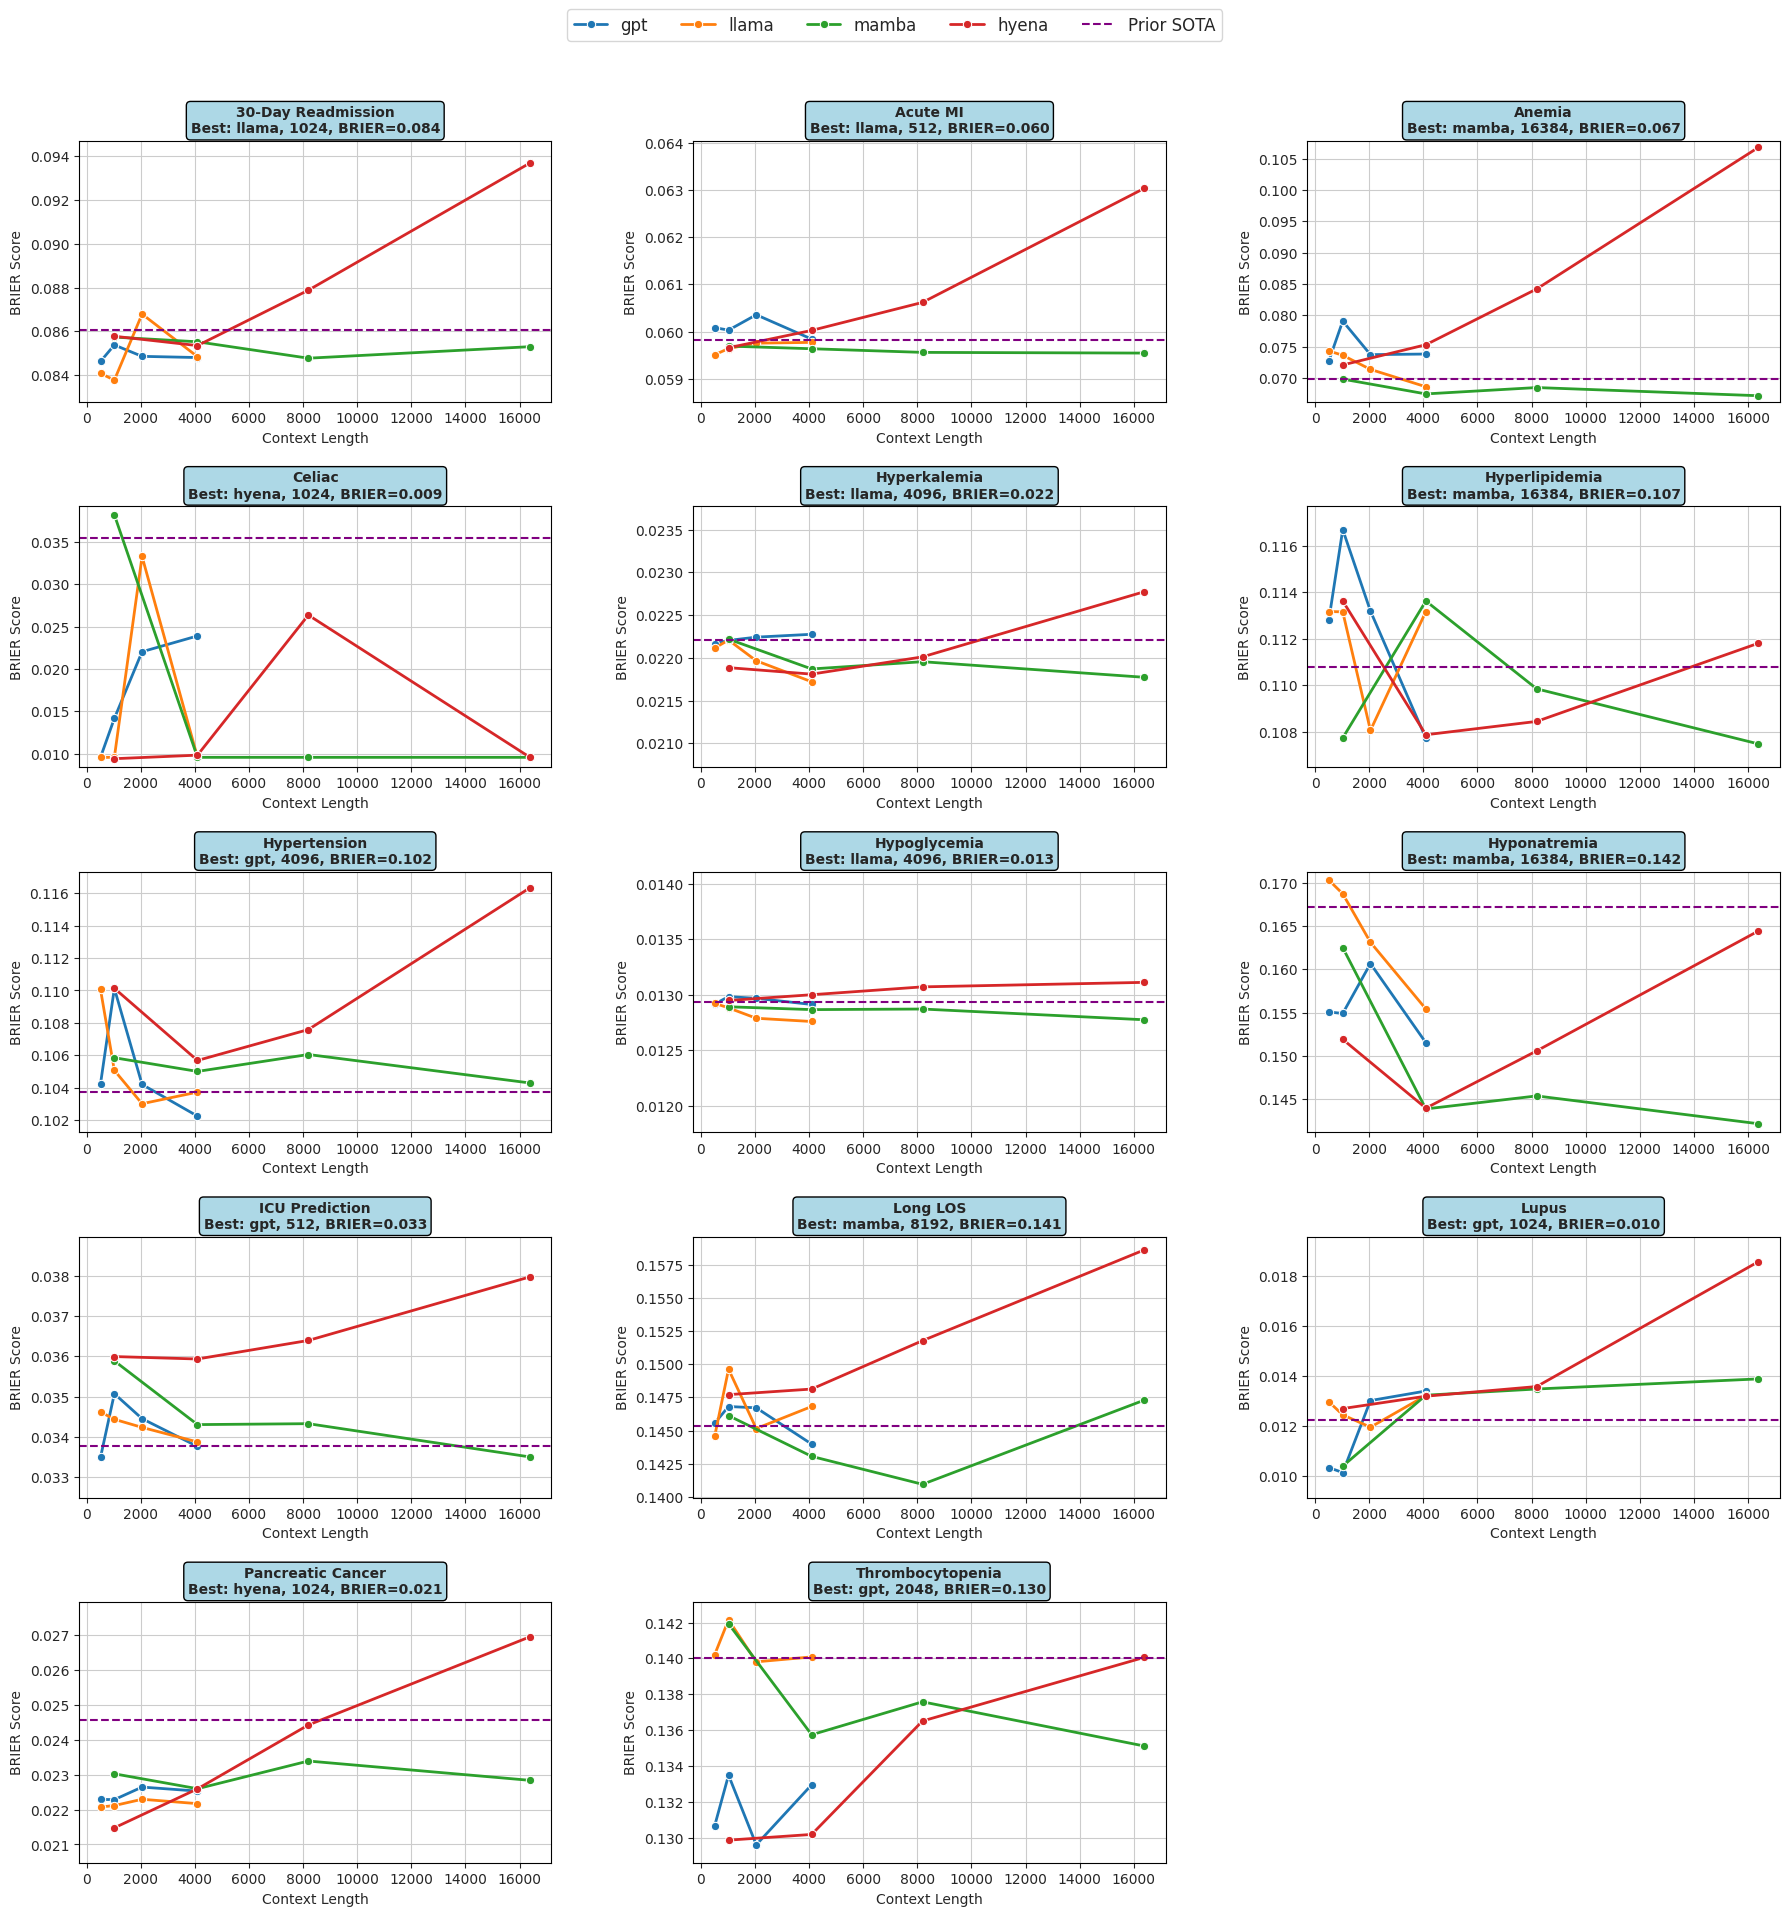


BRIER Summary Table saved to brier_summary_table_context_length_architectire.csv


In [19]:
combined_summary = process_all_tasks_for_plotting()
plot_all_tasks_in_one_frame(combined_summary, "brier_by_context_length_and_architecture_fixed.png")

In [20]:
df_mean = combined_summary.groupby(['architecture', 'context_length'])['value_mean'].mean().reset_index()
print(df_mean)

   architecture  context_length  value_mean
0           gpt             512    0.069755
1           gpt            1024    0.071668
2           gpt            2048    0.071479
3           gpt            4096    0.070404
4         hyena            1024    0.070368
5         hyena            4096    0.069487
6         hyena            8192    0.073104
7         hyena           16384    0.077414
8         llama             512    0.072182
9         llama            1024    0.072106
10        llama            2048    0.072402
11        llama            4096    0.070410
12        mamba            1024    0.073004
13        mamba            4096    0.069164
14        mamba            8192    0.069153
15        mamba           16384    0.068760


In [21]:
keys_to_remove = ['Chexpert']
new_dict = {k: v for k, v in baseline_and_sota.items() if k not in keys_to_remove}
average_clmbr_brier = sum(new_dict[k]['CLMBR'] for k in new_dict.keys()) / len(new_dict.keys())
print(f"CLMBR AVG BRIER SCORE: {average_clmbr_brier}")

CLMBR AVG BRIER SCORE: 0.07314231042484971


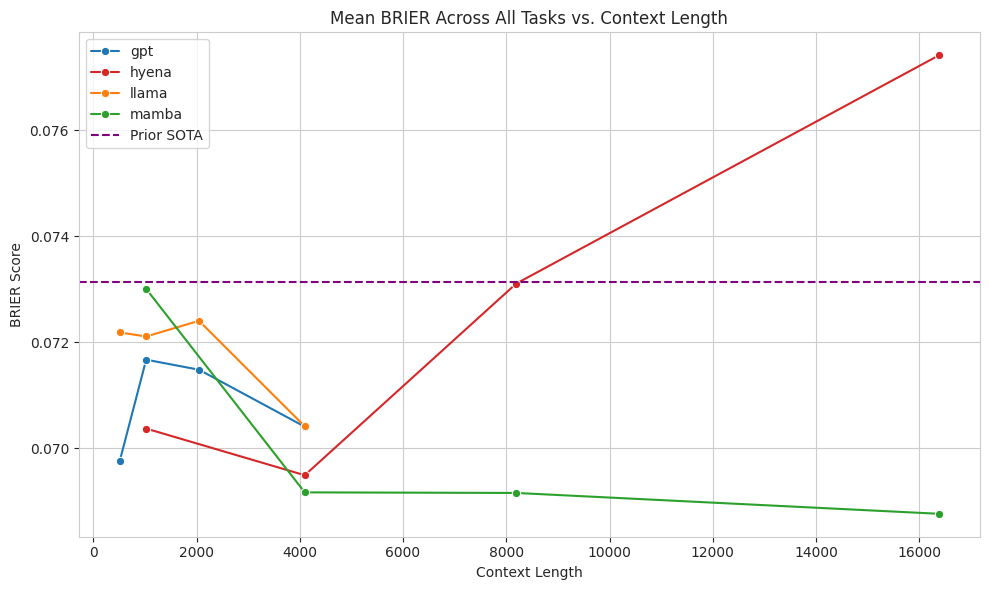

In [22]:
tab10 = plt.get_cmap('tab10')

# Define a custom color palette using the first 4 colors from tab10
custom_palette = {
    'gpt': tab10(0),  # blue
    'mamba': tab10(2),  # orange
    'hyena': tab10(3),  # green
    'llama': tab10(1)   # red
}

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_mean, x='context_length', y='value_mean', hue='architecture', marker='o', palette=custom_palette)

# Customize the plot
plt.title('Mean BRIER Across All Tasks vs. Context Length')
plt.xlabel('Context Length')
plt.ylabel('BRIER Score')

plt.axhline(y=average_clmbr_brier, color='purple', linestyle='--', label='Prior SOTA')
plt.legend()
# Show the plot
plt.tight_layout()
plt.grid(True)
plt.savefig('brier_by_context_length.png')
plt.show()